In [6]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [7]:
model_folders = os.listdir('saved_models/')
model_folders

['w2v_d2v_kwords_lemmatize',
 'w2v_d2v_100',
 'doc2_vec_czech_small',
 'w2v_czech',
 'doc2vec_czech',
 'ud_pipe_czech_text',
 'd2v_w2v_kwords_nolemma']

In [10]:
with open(os.path.join('saved_models', 'd2v_w2v_kwords_nolemma', 'vectors.pickle'), 'rb') as handle:
    vectors = pickle.load(handle)
    
with open(os.path.join('saved_models', 'd2v_w2v_kwords_nolemma', 'hopkins.txt')) as handle:
    hp = handle.readlines() 

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/d2v_w2v_kwords_nolemma/hopkins.txt'

In [22]:
project_df = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
project_df.columns

Index(['Kód projektu', 'Název česky', 'Název anglicky', 'Anotace česky',
       'Anotace anglicky', 'Hlavní CEP obor', 'Vedlejší CEP obor',
       'Další vedlejší CEP obor', 'Hlavní FORD obor', 'Vedlejší FORD obor',
       'Další vedlejší FORD obor', 'Kategorie VaV', 'Hlavní účastníci',
       'Další účastníci', 'Výčet právních forem účastníků',
       'Výčet krajů účastníků', 'Výčet zemí účastníků',
       'Podrobné informace o účastnících', 'Hlavní řešitelé', 'Další řešitelé',
       'Klíčová slova', 'Výčet druhů dosažených výsledků', 'Poskytovatel',
       'Program', 'Uznané náklady', 'Podpora ze SR',
       'Ostatní veřejné zdroje fin.', 'Neveřejné zdroje fin.',
       'Začátek řešení', 'Konec řešení', 'URL v Starfose', 'Relevance'],
      dtype='object')

In [24]:
subset_df = project_df[['Název česky', 'Anotace česky', 'Hlavní CEP obor', 'Hlavní účastníci', 'Hlavní řešitelé', 'Klíčová slova', 'Poskytovatel']]

In [30]:
subset_df.dropna(inplace=True)
subset_df.reset_index(inplace=True, drop=True)

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
def scatter_plot(src_df, x=None, y=None, hover_columns=None, size=None, size_scale=20, 
                 color=None, title=None, x_title=None, y_title=None):
    df = src_df.copy()
    hover_text = []
    bubble_size = []

    for index, row in df.iterrows():
        text = '<br>'.join([f'{column}: {row[column]}' for column in hover_columns])
        hover_text.append(text)
        bubble_size.append(row[size] * size_scale)

    df['text'] = hover_text
    df['size'] = bubble_size
    sizeref = 2.*max(df['size'])/(size_scale**2)

    categories = df[color].unique().tolist()
    categorical_data = {category:df.query(f'{color} == "{category}"') for category in categories}
    
    fig = go.Figure()

    for c_name, c in categorical_data.items():
        fig.add_trace(go.Scatter(
            x=c[x], y=c[y], name=c_name, text=c['text'], marker_size=c['size']
        ))

    fig.update_traces(mode='markers', marker=dict(sizemode='area', sizeref=sizeref, line_width=2))
    fig.update_layout(
        title=title,
        xaxis=dict(
            title=x_title,
            gridcolor='white',
            gridwidth=2,
        ),
        yaxis=dict(
            title=y_title,
            gridcolor='white',
            gridwidth=2,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
    )
    fig.show()

In [61]:
clusterer = KMeansClusterer(12, euclidean_distance)
clustered = clusterer.cluster(vectors['doc2vec_200_500'], assign_clusters=True)

In [72]:
#tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=25000)
#tsne_clusters = tsne_model.fit_transform(vectors['doc2vec_200_500'])

x, y = [], []
for value in tsne_clusters:
    x.append(value[0])
    y.append(value[1])
    
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['cluster'] = clustered
df['name'] = subset_df['Název česky']
df['obor'] = subset_df['Hlavní CEP obor']
df['poskytovatel'] = subset_df['Poskytovatel']
df['kwords'] = subset_df['Klíčová slova']
df['size'] = 1

scatter_plot(df.sample(10), x='x', y='y', 
            hover_columns=['poskytovatel', 'obor', 'name'],
            size='size', color='cluster', title='Vizualizace clusteru TSNE',
            x_title='X', y_title='Y', size_scale=20)

In [76]:
pd.set_option('display.max_rows', 2000)
df[df['cluster'] == 0]

,x,y,cluster,name,obor,poskytovatel,kwords,size
24,-8.205750,10.901315,0,Systém automatizované kontroly a detekce změn ...,"JD - Využití počítačů, robotika a její aplikace",MD - Ministerstvo dopravy,monitorovací; systém; bezpečnostní; politika; ...,1
28,-0.430785,-1.635515,0,Vazba napáječových rychlovypínačů,JO - Pozemní dopravní systémy a zařízení,MD - Ministerstvo dopravy,vazba napáječů; MPLS; QoS,1
31,3.963392,3.171453,0,Snížení energetické náročnosti průmyslových ch...,"JE - Nejaderná energetika, spotřeba a užití en...",MŽP - Ministerstvo životního prostředí,Industrial refrigeration plants; energy consum...,1
53,-2.247636,6.359787,0,Vývoj detektorů RICH s velmi malou radiační dé...,BF - Elementární částice a fyzika vysokých ene...,"MŠMT - Ministerstvo školství, mládeže a tělový...",detectors RICH; small radiation lenght; optics...,1
56,-6.503001,17.081818,0,CERN-COMPASS,BF - Elementární částice a fyzika vysokých ene...,"MŠMT - Ministerstvo školství, mládeže a tělový...",CERN - COMPASS; co-ordinated participation of ...,1
67,11.520204,-5.331659,0,Dekolorizace a detoxifikace textilních odpadní...,DJ - Znečištění a kontrola vody,"MŠMT - Ministerstvo školství, mládeže a tělový...",Decolorisation; Detoxification; Waste Water; T...,1
118,-17.372562,5.995394,0,Realizace modulární aparatury pro plazmově pol...,BL - Fyzika plasmatu a výboje v plynech,"MŠMT - Ministerstvo školství, mládeže a tělový...",design of the modular apparatus; plasma polyme...,1
133,2.433946,-3.479563,0,Vývoj 3D simulačního softwaru pro tvarování ob...,JC - Počítačový hardware a software,"MŠMT - Ministerstvo školství, mládeže a tělový...",3D Simulation software Developments; container...,1
134,-4.031933,7.974763,0,Fúzní reaktor ITER: výzkum pevnosti připojení ...,"AE - Řízení, správa a administrativa","MŠMT - Ministerstvo školství, mládeže a tělový...",fusion reactor ITER; strengh of the PFW panel ...,1
162,3.045292,-10.925903,0,Sezónní kavernové úložiště solární tepelné ene...,"JE - Nejaderná energetika, spotřeba a užití en...","MŠMT - Ministerstvo školství, mládeže a tělový...",CTES; Cavern heat storage; crystalline rocks; ...,1


In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [78]:
model = Doc2Vec.load('saved_models/doc2vec_czech/doc2vec_200_500')

In [97]:
vec = model.infer_vector(['reactor', 'fusion', 'electricity'])
model.dv.most_similar([vec])

[(4417, 0.37225183844566345),
 (11839, 0.3557213246822357),
 (4204, 0.3543543815612793),
 (6955, 0.3523018956184387),
 (10558, 0.3425559997558594),
 (4405, 0.3395600914955139),
 (13921, 0.33677059412002563),
 (8219, 0.33286604285240173),
 (4014, 0.3311384618282318),
 (12414, 0.32805365324020386)]

In [107]:
vectors = [model.dv[i] for i in range(1, len(model.dv))]
np.argmax(model.dv.cosine_similarities(model.dv[0], vectors))

7025

In [109]:
df.iloc[0]

x                                                         9.77078
y                                                        -0.87377
cluster                                                        11
name            Frekvence a distribuce inzulinorezistence, jak...
obor            FB - Endokrinologie, diabetologie, metabolismu...
poskytovatel                      MZ - Ministerstvo zdravotnictví
kwords          insulin resistance; quantitative indexes; HOMA...
size                                                            1
Name: 0, dtype: object

In [110]:
df.iloc[7025]

x                                                         21.7537
y                                                         7.93004
cluster                                                         4
name            Trendy sociálně politických mechnizmů ovlivňuj...
obor                                  AO - Sociologie, demografie
poskytovatel          MPSV - Ministerstvo práce a sociálních věcí
kwords          position of women in Czech society; politics o...
size                                                            1
Name: 7025, dtype: object

In [12]:
from pyclustertend import hopkins
from tqdm import tqdm

def calc_hopkins_score(vector):
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    df = pd.DataFrame(vector)
    hs = hopkins(df, vector.shape[0])
    return hs

def eval_using_hopkins_test(results_dir, results):
    with open(os.path.join(results_dir, 'hopkins.txt'), 'w') as handle:
        for name, vector in tqdm(results.items()):
            if vector.shape[0] * vector.shape[1] >= 1e8:
                print('Vector too large, skipping.')
                continue
            hs = calc_hopkins_score(vector)
            handle.write(f'Hopkins score for {name}: {hs:5f}\n')
            print(f'Hopkins score for {name}: {hs:5f}\n')

In [4]:
with open('saved_models/w2v_d2v_kwords_lemmatize/vectors.pickle', 'rb') as handle:
    vectors = pickle.load(handle)

In [14]:
for dir_ in os.listdir('saved_models'):
    if 'hopkins.txt' not in os.listdir(os.path.join('saved_models', dir_)):
        print(f'Generating hopkins scores for {dir_}')
        with open(os.path.join('saved_models', dir_, 'vectors.pickle'), 'rb') as handle:
            vectors = pickle.load(handle)
        eval_using_hopkins_test(os.path.join('saved_models', dir_), vectors)

Generating hopkins scores for d2v_w2v_kwords_nolemma


  0%|          | 0/54 [00:00<?, ?it/s]

Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.
Vector too large, skipping.


 30%|██▉       | 16/54 [25:02<59:28, 93.91s/it]

Hopkins score for word2vec_(fasttext-wiki-news-subwords-300): 0.083917



 31%|███▏      | 17/54 [58:14<2:33:50, 249.48s/it]

Hopkins score for word2vec_(word2vec-google-news-300): 0.128352



 33%|███▎      | 18/54 [1:03:45<2:34:49, 258.03s/it]

Hopkins score for word2vec_(glove-wiki-gigaword-50): 0.138081



 35%|███▌      | 19/54 [1:16:09<3:07:27, 321.36s/it]

Hopkins score for word2vec_(glove-wiki-gigaword-100): 0.142312



 37%|███▋      | 20/54 [1:39:08<4:36:06, 487.24s/it]

Hopkins score for word2vec_(glove-wiki-gigaword-200): 0.142170



 39%|███▉      | 21/54 [2:10:51<6:50:33, 746.46s/it]

Hopkins score for word2vec_(glove-wiki-gigaword-300): 0.141136



 41%|████      | 22/54 [2:12:38<5:27:23, 613.87s/it]

Hopkins score for word2vec_(glove-twitter-25): 0.115305



 43%|████▎     | 23/54 [2:18:13<4:44:13, 550.10s/it]

Hopkins score for word2vec_(glove-twitter-50): 0.127026



 44%|████▍     | 24/54 [2:30:19<4:56:41, 593.38s/it]

Hopkins score for word2vec_(glove-twitter-100): 0.135199



 46%|████▋     | 25/54 [2:52:59<6:23:11, 792.80s/it]

Hopkins score for word2vec_(glove-twitter-200): 0.139014



 48%|████▊     | 26/54 [2:53:19<4:32:16, 583.43s/it]

Hopkins score for word2vec_25: 0.048890



 50%|█████     | 27/54 [2:54:03<3:14:48, 432.89s/it]

Hopkins score for word2vec_50: 0.044265



 52%|█████▏    | 28/54 [2:55:21<2:23:45, 331.75s/it]

Hopkins score for word2vec_100: 0.039326



 54%|█████▎    | 29/54 [2:57:46<1:55:46, 277.84s/it]

Hopkins score for word2vec_200: 0.037462



 56%|█████▌    | 30/54 [3:00:50<1:40:06, 250.26s/it]

Hopkins score for doc2vec_25_10: 0.176119



 57%|█████▋    | 31/54 [3:04:14<1:30:46, 236.79s/it]

Hopkins score for doc2vec_25_50: 0.229901



 59%|█████▉    | 32/54 [3:07:34<1:22:47, 225.79s/it]

Hopkins score for doc2vec_25_100: 0.237561



 61%|██████    | 33/54 [3:11:00<1:16:55, 219.80s/it]

Hopkins score for doc2vec_25_200: 0.240427



 63%|██████▎   | 34/54 [3:14:24<1:11:44, 215.20s/it]

Hopkins score for doc2vec_25_300: 0.242236



 65%|██████▍   | 35/54 [3:21:50<1:29:58, 284.15s/it]

Hopkins score for doc2vec_50_10: 0.191472



 67%|██████▋   | 36/54 [3:30:06<1:44:12, 347.37s/it]

Hopkins score for doc2vec_50_50: 0.238356



 69%|██████▊   | 37/54 [3:38:22<1:51:01, 391.85s/it]

Hopkins score for doc2vec_50_100: 0.242348



 70%|███████   | 38/54 [3:46:35<1:52:38, 422.39s/it]

Hopkins score for doc2vec_50_200: 0.244370



 72%|███████▏  | 39/54 [3:54:49<1:50:56, 443.78s/it]

Hopkins score for doc2vec_50_300: 0.242172



 74%|███████▍  | 40/54 [4:08:30<2:09:56, 556.92s/it]

Hopkins score for doc2vec_100_10: 0.184032



 76%|███████▌  | 41/54 [4:22:45<2:20:00, 646.23s/it]

Hopkins score for doc2vec_100_50: 0.221482



 78%|███████▊  | 42/54 [4:36:57<2:21:35, 707.93s/it]

Hopkins score for doc2vec_100_100: 0.222072



 80%|███████▉  | 43/54 [4:51:02<2:17:17, 748.88s/it]

Hopkins score for doc2vec_100_200: 0.221872



 81%|████████▏ | 44/54 [5:04:43<2:08:26, 770.63s/it]

Hopkins score for doc2vec_100_300: 0.219319



 83%|████████▎ | 45/54 [5:27:39<2:22:49, 952.13s/it]

Hopkins score for doc2vec_200_10: 0.179514



 85%|████████▌ | 46/54 [5:51:50<2:26:56, 1102.02s/it]

Hopkins score for doc2vec_200_50: 0.212343



 87%|████████▋ | 47/54 [6:16:48<2:22:24, 1220.70s/it]

Hopkins score for doc2vec_200_100: 0.211713



 89%|████████▉ | 48/54 [6:41:53<2:10:36, 1306.02s/it]

Hopkins score for doc2vec_200_200: 0.213221



 91%|█████████ | 49/54 [7:06:58<1:53:49, 1365.81s/it]

Hopkins score for doc2vec_200_300: 0.213764



 93%|█████████▎| 50/54 [7:41:08<1:44:43, 1570.82s/it]

Hopkins score for doc2vec_300_10: 0.178918



 94%|█████████▍| 51/54 [8:16:10<1:26:30, 1730.24s/it]

Hopkins score for doc2vec_300_50: 0.208706



 96%|█████████▋| 52/54 [8:53:15<1:02:37, 1878.72s/it]

Hopkins score for doc2vec_300_100: 0.210782



 98%|█████████▊| 53/54 [9:28:54<32:36, 1956.67s/it]  

Hopkins score for doc2vec_300_200: 0.210776



100%|██████████| 54/54 [10:03:45<00:00, 670.85s/it] 

Hopkins score for doc2vec_300_300: 0.211108



In [15]:
for dir_ in os.listdir('saved_models'):

['w2v_d2v_kwords_lemmatize',
 'w2v_d2v_100',
 'doc2_vec_czech_small',
 'w2v_czech',
 'doc2vec_czech',
 'ud_pipe_czech_text',
 'd2v_w2v_kwords_nolemma']

In [18]:
from sys import getsizeof
getsizeof(vectors)

2288

In [19]:
df = pd.DataFrame(vectors)
display(df)
print(getsizeof(df))

ValueError: If using all scalar values, you must pass an index

In [34]:
store.close()
store = pd.HDFStore('saved_models/vectors.h5', mode='w')

store.put('word2vec_(fasttext-wiki-news-subwords-300)', pd.DataFrame(vectors['word2vec_(fasttext-wiki-news-subwords-300)']), format='table', append=True) 

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'word2vec_(fasttext-wiki-news-subwords-300)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [36]:
store['word2vec_(fasttext-wiki-news-subwords-300)']

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.033194,-0.013342,0.015515,-0.001139,-0.028825,-0.000079,-0.007146,-0.097313,0.048155,0.031348,...,0.001149,-0.008887,-0.048789,-0.053378,-0.011413,0.014594,0.022180,-0.017404,0.015753,0.020052
1,-0.005233,-0.009963,0.024714,0.000140,-0.008300,0.021717,0.007352,-0.090781,0.013698,-0.038160,...,0.055167,0.043936,-0.035996,-0.041789,0.021586,-0.050204,-0.012557,0.020938,0.015376,0.017723
2,-0.027992,-0.029501,0.011585,-0.002073,-0.029769,-0.031830,0.017413,-0.051006,0.003315,-0.013601,...,0.004842,0.055940,-0.073676,-0.033175,0.034859,-0.036480,-0.007892,-0.000060,-0.007591,-0.030003
3,-0.025169,-0.011007,0.004713,0.029161,0.001748,-0.019382,0.013728,-0.061973,-0.007224,-0.016626,...,-0.016646,0.001789,-0.023575,-0.033310,0.013550,-0.015586,0.009387,0.004025,0.023069,0.017309
4,-0.026564,-0.017630,0.019459,0.009240,-0.016886,-0.007118,0.056226,-0.067837,0.004595,-0.001588,...,0.033728,0.029864,-0.057730,-0.039725,0.020521,-0.019973,0.005985,-0.010311,-0.020510,-0.008998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39709,0.015386,-0.093637,0.042875,0.051619,-0.041561,-0.077336,0.031103,0.044598,0.027542,-0.057577,...,-0.017249,0.035759,-0.029270,-0.009495,0.029184,0.000668,0.000930,0.021590,-0.004583,0.019441
39710,0.000496,-0.080699,0.077644,0.008848,-0.082262,-0.054081,0.037610,0.125024,-0.010789,-0.030006,...,0.001206,0.058586,-0.137666,-0.055534,0.028854,-0.013776,-0.018222,0.005624,-0.011412,0.022709
39711,-0.020029,0.004452,0.016306,0.008723,0.033284,-0.034207,0.046362,-0.079446,0.036588,0.021446,...,-0.036764,0.043607,-0.019769,-0.031643,0.025733,-0.022155,0.033062,0.003561,0.034074,0.000676
39712,0.025439,-0.034272,-0.014866,0.049625,0.019115,-0.012768,0.017416,-0.044389,-0.010930,-0.041666,...,-0.020493,0.011441,0.020486,-0.010542,0.006846,0.028249,-0.008068,0.034248,0.001176,-0.017319


100%|██████████| 54/54 [11:00:14<00:00, 733.61s/it]    


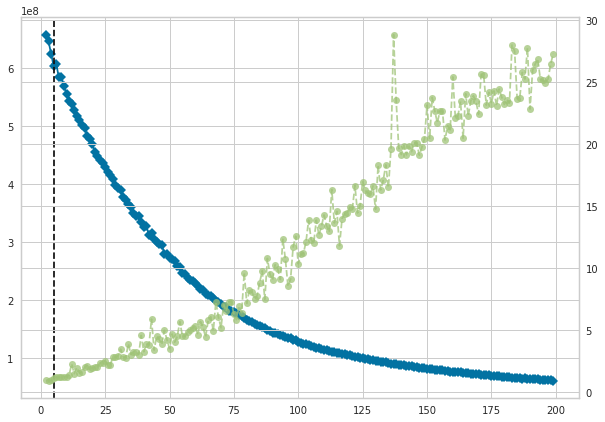

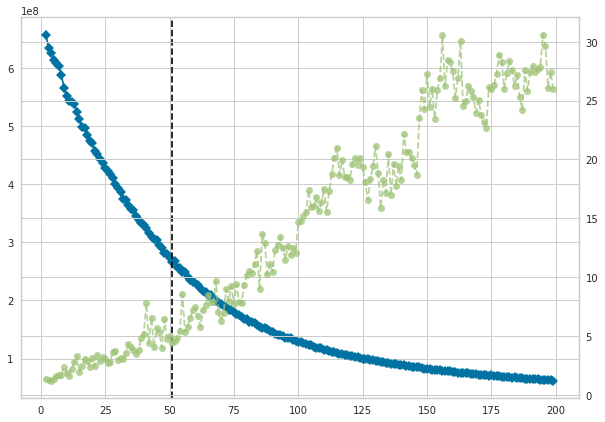

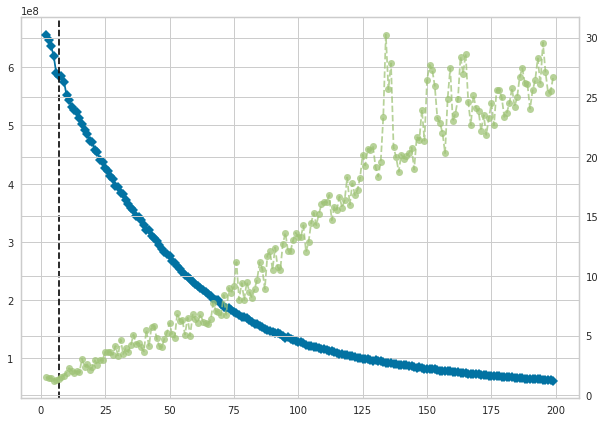

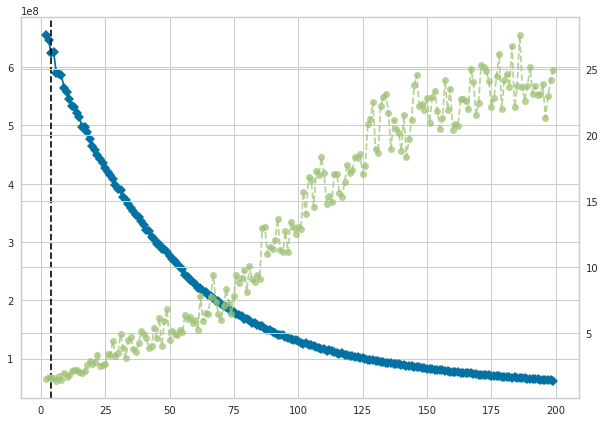

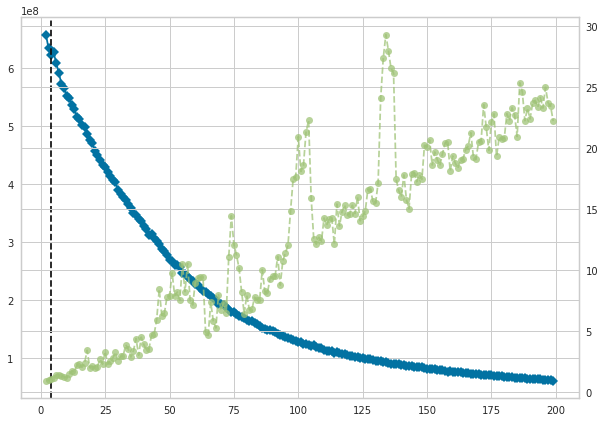

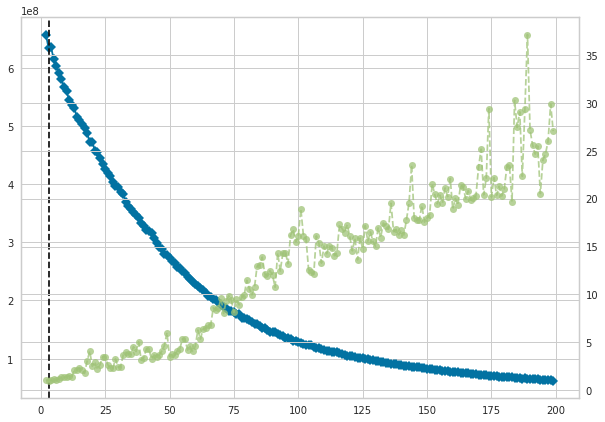

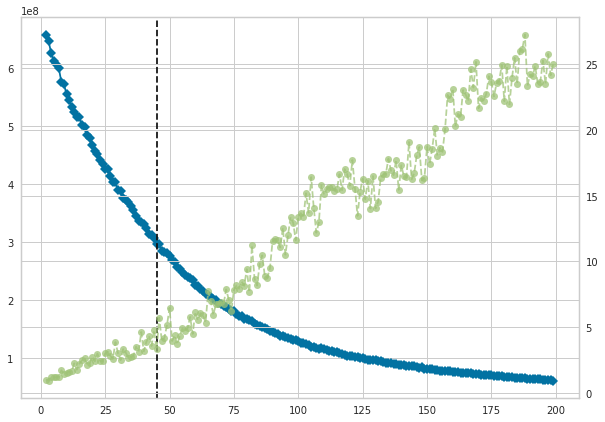

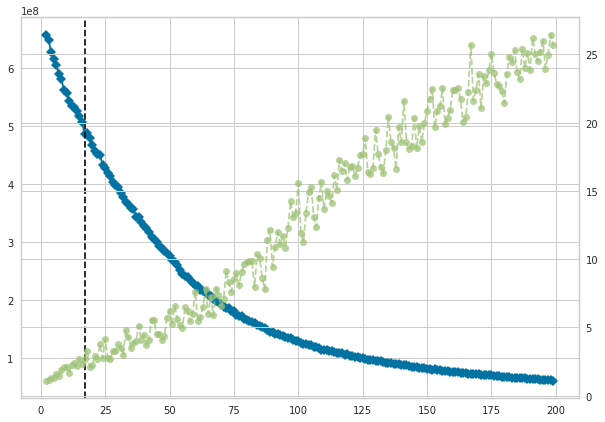

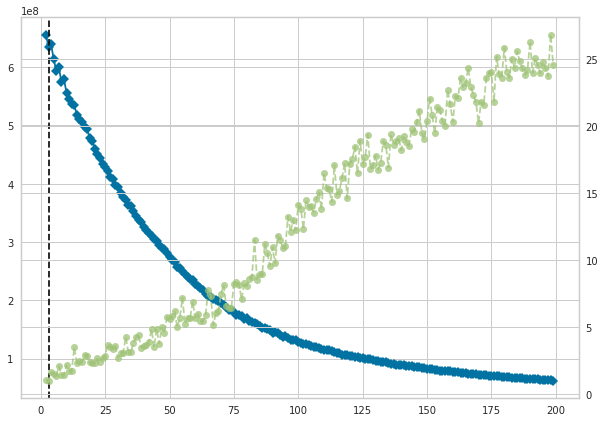

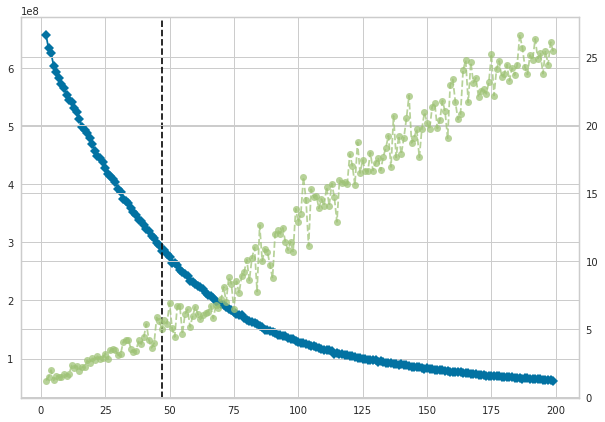

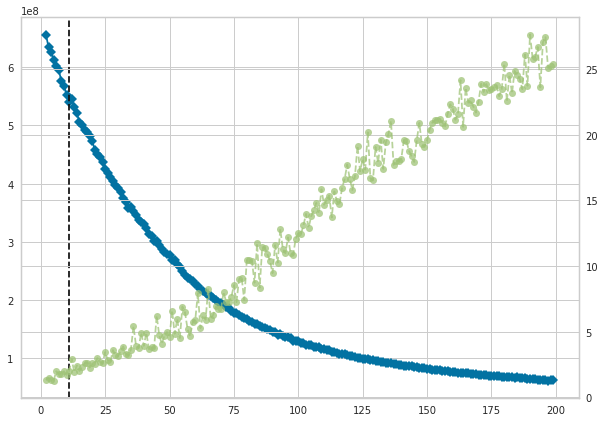

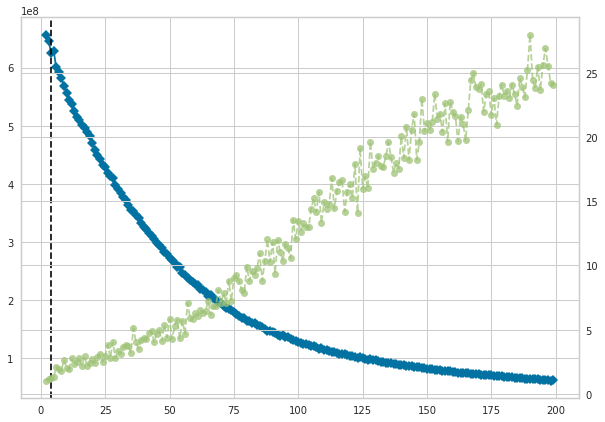

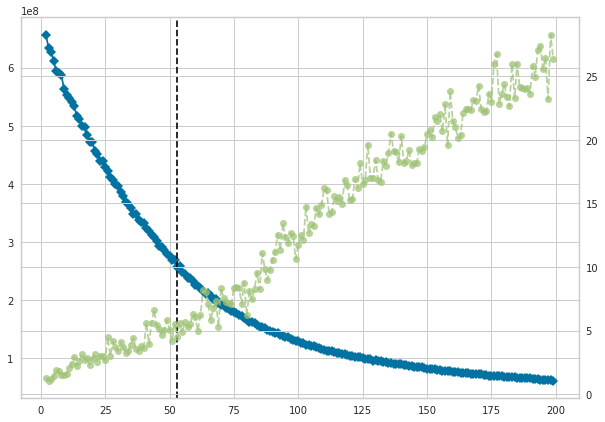

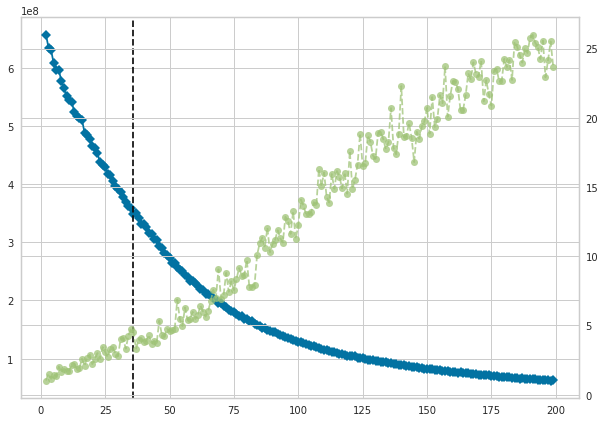

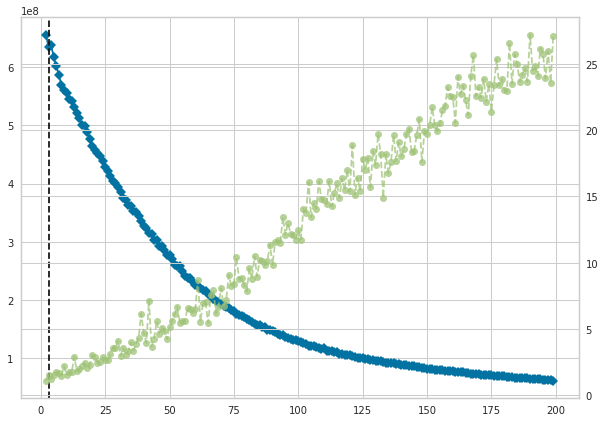

In [7]:
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding, TSNE
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

scaler = StandardScaler(with_mean=False)
lle = LocallyLinearEmbedding(n_components=100, random_state=42)
svd = TruncatedSVD(n_components=100, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2, random_state=42)

model = KMeans()

pipe = Pipeline([
    ('scaler', scaler),
    ('svd', svd)
])

with open('saved_models/d2v_w2v_kwords_nolemma/vectors.pickle', 'rb') as handle:
    vectors = pickle.load(handle)

for key in tqdm(vectors.keys()):
    if 'tf-idf' in key: 
        plt.figure(figsize=(10, 7))
        visualizer = KElbowVisualizer(model, k=(2,200), ax=plt)
        transformed = pipe.fit_transform(vectors[key])
        visualizer.fit(transformed)
        plt.savefig(f'saved_models/d2v_w2v_kwords_nolemma/kelbow_{key}.png')

NameError: name 'vectors' is not defined

[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


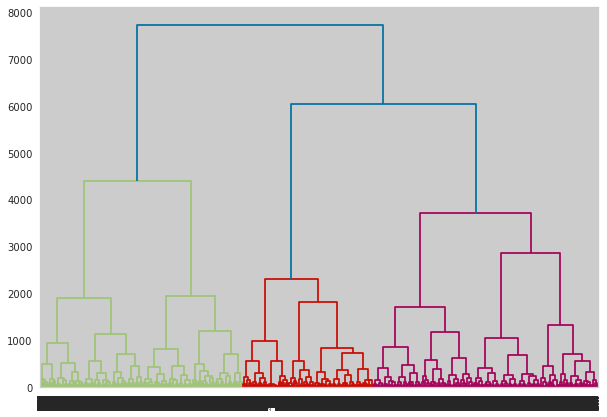

In [84]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(transformed, 'ward')

labels = list(range(1, len(transformed) + 1))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)

plt.plot()

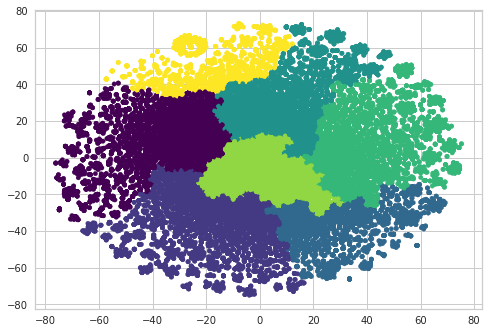

In [121]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
predicted_clusters = cluster.fit_predict(transformed)

plt.scatter(transformed[:, 0], transformed[:, 1], marker='o', c=predicted_clusters, s=20, cmap='viridis')

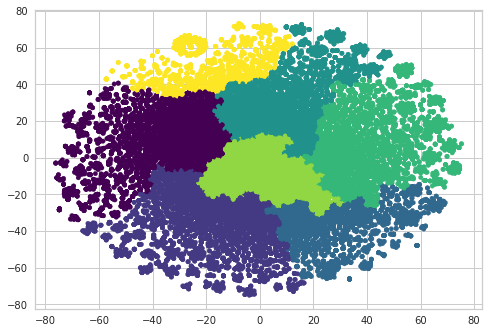

In [123]:
plt.scatter(transformed[:, 0], transformed[:, 1], marker='o', c=predicted_clusters, s=20, cmap='viridis')
plt.savefig('agglomerative_7_clusters_pca.png')

In [124]:
df = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
df.columns

Index(['Kód projektu', 'Název česky', 'Název anglicky', 'Anotace česky',
       'Anotace anglicky', 'Hlavní CEP obor', 'Vedlejší CEP obor',
       'Další vedlejší CEP obor', 'Hlavní FORD obor', 'Vedlejší FORD obor',
       'Další vedlejší FORD obor', 'Kategorie VaV', 'Hlavní účastníci',
       'Další účastníci', 'Výčet právních forem účastníků',
       'Výčet krajů účastníků', 'Výčet zemí účastníků',
       'Podrobné informace o účastnících', 'Hlavní řešitelé', 'Další řešitelé',
       'Klíčová slova', 'Výčet druhů dosažených výsledků', 'Poskytovatel',
       'Program', 'Uznané náklady', 'Podpora ze SR',
       'Ostatní veřejné zdroje fin.', 'Neveřejné zdroje fin.',
       'Začátek řešení', 'Konec řešení', 'URL v Starfose', 'Relevance'],
      dtype='object')

In [125]:
kwords = df[['Klíčová slova', 'Hlavní CEP obor']]
kwords = kwords[~kwords['Klíčová slova'].isna()]
len(kwords) == len(transformed)

kwords['cluster'] = predicted_clusters
kwords.head()

,Klíčová slova,Hlavní CEP obor,cluster
0,allopregnanolone; pregnenolone; isomers of pregnanolone; ejaculation; orgasm; male reproduction,"FB - Endokrinologie, diabetologie, metabolismus, výživa",1
1,cystic fibrosis; newborn screening; immunoreactive trypsin; CFTR gen,"FB - Endokrinologie, diabetologie, metabolismus, výživa",5
2,brain tumours; chromosomal aberration; molecular cytogenetics; I-FISH; prognostic factors; instability of genome,EB - Genetika a molekulární biologie,1
3,modeling; antitubercular; antifungal; cytotoxicity; synthesis; lipophilicity,FR - Farmakologie a lékárnická chemie,2
4,genetic diseases; metabolism; diagnostic; molecular basis; pathogenesis; DNA microarrays; gene expression; genomics,EB - Genetika a molekulární biologie,3


In [127]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

for i in range(7):
    most_common = kwords[kwords['cluster'] == i]['Hlavní CEP obor'].value_counts()[0:2].index.tolist()
    print(f'Cluster {i}: {most_common}')
    

Cluster 0: ['EB - Genetika a molekulární biologie', 'FH - Neurologie, neurochirurgie, neurovědy']
Cluster 1: ['EB - Genetika a molekulární biologie', 'FD - Onkologie a hematologie']
Cluster 2: ['EB - Genetika a molekulární biologie', 'CF - Fyzikální chemie a teoretická chemie']
Cluster 3: ['JA - Elektronika a optoelektronika, elektrotechnika', 'AB - Dějiny']
Cluster 4: ['JA - Elektronika a optoelektronika, elektrotechnika', 'BM - Fyzika pevných látek a magnetismus']
Cluster 5: ['JA - Elektronika a optoelektronika, elektrotechnika', 'EB - Genetika a molekulární biologie']
Cluster 6: ['JA - Elektronika a optoelektronika, elektrotechnika', 'JQ - Strojní zařízení a nástroje']


In [118]:
kwords[kwords['cluster'] == 13]

,Klíčová slova,Hlavní CEP obor,cluster
13,Charcot-Marie-Tooth; GDAP1; NEFL; LITAF1; PRX; HMSN; myelin; axon,"FH - Neurologie, neurochirurgie, neurovědy",13
37,cyclosporine; metabolites; transplantation; lymphocytes; TDM; LC-MS; RIA; rejection,FR - Farmakologie a lékárnická chemie,13
86,Efficiency of environmental care; evaluation of the efficiency; penalties for polluting the environment,AH - Ekonomie,13
87,Accounting; Environmental Accounting; Environmental Policy,AH - Ekonomie,13
92,Czech Republic; Environmental Policy; Macroaggregates; Models,AH - Ekonomie,13
...,...,...,...
53233,science; research; development; exhibition; applied research,EH - Ekologie – společenstva,13
53324,regional development; differences; discrepancies; region; district; municipality; foreign experience,AH - Ekonomie,13
53336,disparities; regional development; criteria of disparities; assessment model; database,"AP - Městské, oblastní a dopravní plánování",13
53346,accessibility; public sector websites,IN - Informatika,13
